# Combining Categorical and Numerical Features with Text in BERT

# 1. Clothing Review Dataset

## 1.1 Download & Parse
Retrieve the .csv file for the dataset.

In [1]:
import gdown

print('Downloading dataset...\n')
     
# Download the file.
gdown.download('https://drive.google.com/uc?id=1ZYdt0zN4LjWqP3cQDblNhXjeohcryY5H', 
                'Womens Clothing E-Commerce Reviews.csv', 
                quiet=False)
    
print('\n\nDONE.')

Downloading...
From: https://drive.google.com/uc?id=1ZYdt0zN4LjWqP3cQDblNhXjeohcryY5H
To: C:\workspace\ksa_nlp_expert\pytorch_seq2seq\Womens Clothing E-Commerce Reviews.csv
8.48MB [00:01, 8.42MB/s]



DONE.


Parse the dataset csv file into a pandas DataFrame.

In [2]:
import pandas as pd


data_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)
data_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## 1.2 Train-Validation-Test Split

In [3]:
import random
import numpy as np

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(data_df))
val_size = int(0.1 * len(data_df))
test_size = len(data_df) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(data_df))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(data_df))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 18,788
Validation size: 2,348
      Test size: 2,350


# 2. Baseline Strategies

## 2.1 Always Recommend

In [4]:
from sklearn.metrics import f1_score

# Select the test set samples.
test_df = data_df.iloc[test_idx]

# Create a list of all 1s to use as our predictions.
predictions = [1]*len(test_df)

# Calculate the F1 score.
f1 = f1_score(y_true=test_df["Recommended IND"], y_pred=predictions)

print('If we always recommend the product...')
print('\nF1: %.3f' % f1)

If we always recommend the product...

F1: 0.908


## 2.2 Threshold on Rating

In [5]:
from sklearn.metrics import f1_score

# Predict whether it's recommended based on whether the rating was 3 or higher.
predictions = test_df["Rating"] >= 3

# Calculate the F1 score.
f1 = f1_score(y_true=test_df["Recommended IND"], y_pred=predictions)

print('Recommend if rating >= 3...')
print('\nF1: %.3f' % f1)

Recommend if rating >= 3...

F1: 0.955


## 2.3 XGBoost

### Encode Categories

In [6]:
# First, change the type of the specified columns to "category". This will 
# assign a "code" to each unique category value.
data_df["Clothing ID"] = data_df["Clothing ID"].astype('category')
data_df["Division Name"] = data_df["Division Name"].astype('category')
data_df["Department Name"] = data_df["Department Name"].astype('category')
data_df["Class Name"] = data_df["Class Name"].astype('category')

# Second, replace the strings with their code values.
data_df["Clothing ID"] = data_df["Clothing ID"].cat.codes
data_df["Division Name"] = data_df["Division Name"].cat.codes
data_df["Department Name"] = data_df["Department Name"].cat.codes
data_df["Class Name"] = data_df["Class Name"].cat.codes

# Display the table--notice how the above columns are all integers now.
data_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,2,2,5
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,0,1,3
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,0,1,3
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,1,0,13
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,0,4,0


### Convert Numerical Features to Floats

In [7]:
# Cast the numerical features to floats.
data_df["Age"] = data_df["Age"].astype('float')
data_df["Rating"] = data_df["Rating"].astype('float')
data_df["Positive Feedback Count"] = data_df["Positive Feedback Count"].astype('float')

data_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33.0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,1,0.0,2,2,5
1,1080,34.0,NaN,Love this dress! it's sooo pretty. i happene...,5.0,1,4.0,0,1,3
2,1077,60.0,Some major design flaws,I had such high hopes for this dress and reall...,3.0,0,0.0,0,1,3
3,1049,50.0,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,1,0.0,1,0,13
4,847,47.0,Flattering shirt,This shirt is very flattering to all due to th...,5.0,1,6.0,0,4,0


### Prepare Splits

In [8]:
# Retrieve the labels for each of the splits.
y_train = data_df["Recommended IND"].iloc[train_idx]
y_val = data_df["Recommended IND"].iloc[val_idx]
y_test = data_df["Recommended IND"].iloc[test_idx]

# Before selecting the inputs, remove text columns and the labels.
data_df = data_df.drop(columns=["Title", "Review Text", "Recommended IND"])

# Select the inputs for the different splits.
X_train = data_df.iloc[train_idx]
X_val = data_df.iloc[val_idx]
X_test = data_df.iloc[test_idx]

X_train.head()

,Clothing ID,Age,Rating,Positive Feedback Count,Division Name,Department Name,Class Name
15277,875,52.0,4.0,4.0,0,4,8
22029,909,68.0,5.0,3.0,1,4,4
15422,854,40.0,3.0,1.0,1,4,8
9191,862,35.0,4.0,0.0,0,4,8
467,1078,61.0,5.0,1.0,0,1,3


### Train & Test

In [9]:
from xgboost import XGBClassifier

# Create an instance of the classifier
model = XGBClassifier()

# Train it on the training set.
model.fit(X_train, y_train)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(X_test)

# Calculate the F1 score.
f1 = f1_score(y_true = y_test,
              y_pred = predictions)

print('Using XGBoost on non-text features...')
print('\nF1: %.3f' % f1)

Using XGBoost on non-text features...

F1: 0.956


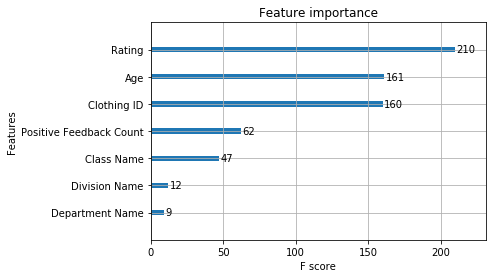

In [10]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)

pyplot.show()

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

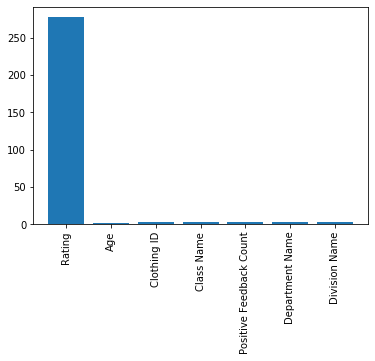

In [11]:
feat_gains = model.get_booster().get_score(importance_type="gain")

pyplot.bar(feat_gains.keys(), feat_gains.values())
pyplot.xticks(rotation = 90)

## 2.4 BERT on Review Text Only

# 3. BERT with All Features

## 3.1 All Features to Text

In [12]:
# This will hold all of the dataset samples, as strings.
sen_w_feats = []

# The labels for the samples.
labels = []

# First, reload the dataset to undo the transformations we applied for XGBoost.
data_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)

# Some of the reviews are missing either a "Title" or "Review Text", so we'll 
# replace the NaN values with empty string.
data_df = data_df.fillna("")


print('Combining features into strings...')

# For each of the samples...
for index, row in data_df.iterrows():

    # Piece it together...    
    combined = ""
    
    #combined += "The ID of this item is {:}, ".format(row["Clothing ID"])
    combined += "This item comes from the {:} department and {:} division, " \
                "and is classified under {:}. ".format(row["Department Name"], 
                                                       row["Division Name"], 
                                                       row["Class Name"])
    
    combined += "I am {:} years old. ".format(row["Age"])
    
    combined += "I rate this item {:} out of 5 stars. ".format(row["Rating"])
    
    # Not all samples have titles.
    if not row["Title"] == "":
        combined += row["Title"] + ". "
    
    # Finally, append the review the text!
    combined += row["Review Text"]
    
    # Add the combined text to the list.
    sen_w_feats.append(combined)

    # Also record the sample's label.
    labels.append(row["Recommended IND"])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))

Combining features into strings...
  DONE.
Dataset contains 23,486 samples.


In [13]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

print(wrapper.fill(sen_w_feats[1]))

This item comes from the Dresses department and General division, and is
classified under Dresses. I am 34 years old. I rate this item 5 out of 5 stars.
Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm
glad i did bc i never would have ordered it online bc it's petite.  i bought a
petite and am 5'8".  i love the length on me- hits just a little below the knee.
would definitely be a true midi on someone who is truly petite.


## 3.2 GPU & Transformers Setup

In [14]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070 SUPER


Load the tokenizer.

In [15]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [16]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
)

# Tell pytorch to run this model on the GPU.
desc = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## 3.3 Training Parameters

In [17]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 4

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 4

In [18]:
max_len = 0

# For every sentence...
for sent in sen_w_feats:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  204


In [19]:
# Let's use a maximum length of 200.
max_len = 200

## 3.4 Tokenize & Encode

In [20]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding all reviews in the dataset...')

# For every sentence...
for sent in sen_w_feats:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('DONE.')

Encoding all reviews in the dataset...
DONE.


In [21]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels[test_idx])

## 3.5 Training

### 3.5.1 Setup

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

In [24]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [25]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 3.5.2 Training Loop

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  4,697.    Elapsed: 0:00:05.
  Batch    80  of  4,697.    Elapsed: 0:00:10.
  Batch   120  of  4,697.    Elapsed: 0:00:14.
  Batch   160  of  4,697.    Elapsed: 0:00:19.
  Batch   200  of  4,697.    Elapsed: 0:00:23.
  Batch   240  of  4,697.    Elapsed: 0:00:28.
  Batch   280  of  4,697.    Elapsed: 0:00:33.
  Batch   320  of  4,697.    Elapsed: 0:00:37.
  Batch   360  of  4,697.    Elapsed: 0:00:42.
  Batch   400  of  4,697.    Elapsed: 0:00:46.
  Batch   440  of  4,697.    Elapsed: 0:00:51.
  Batch   480  of  4,697.    Elapsed: 0:00:55.
  Batch   520  of  4,697.    Elapsed: 0:01:00.
  Batch   560  of  4,697.    Elapsed: 0:01:04.
  Batch   600  of  4,697.    Elapsed: 0:01:09.
  Batch   640  of  4,697.    Elapsed: 0:01:14.
  Batch   680  of  4,697.    Elapsed: 0:01:18.
  Batch   720  of  4,697.    Elapsed: 0:01:23.
  Batch   760  of  4,697.    Elapsed: 0:01:27.
  Batch   800  of  4,697.    Elapsed: 0:01:32.
  Batch   840  of

### 3.5.3 Training Results

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 3.5 Test

In [ ]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
   
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1
f1 = f1_score(flat_true_labels, flat_predictions)

print('F1 Score: %.3f' % f1)